Import the requsite libraries

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

Define the locations of the two model experiments you want to compare. 

In [3]:
ls /mnt/output/tem/tem_ee2_breakout/

baseline_imnavait_tussock/  warming_and_precip_imnavait_tussock/
precip_imnavait_tussock/    warming_imnavait_tussock/


In [4]:
# Replace with the paths to your runs. Will be something like:
#
#    /mnt/output/tem/tem_ee2_breakout/baseline_imnavait_tussock/
#
model_data_control_location = '/mnt/output/tem/tem_ee2_breakout/baseline_imnavait_tussock/'
model_data_treatment_location = '/mnt/output/tem/tem_ee2_breakout/precip_imnavait_tussock/'

Plotting the snow water equivalent and the snow thickness to confirm that the experiment worked as intended: 

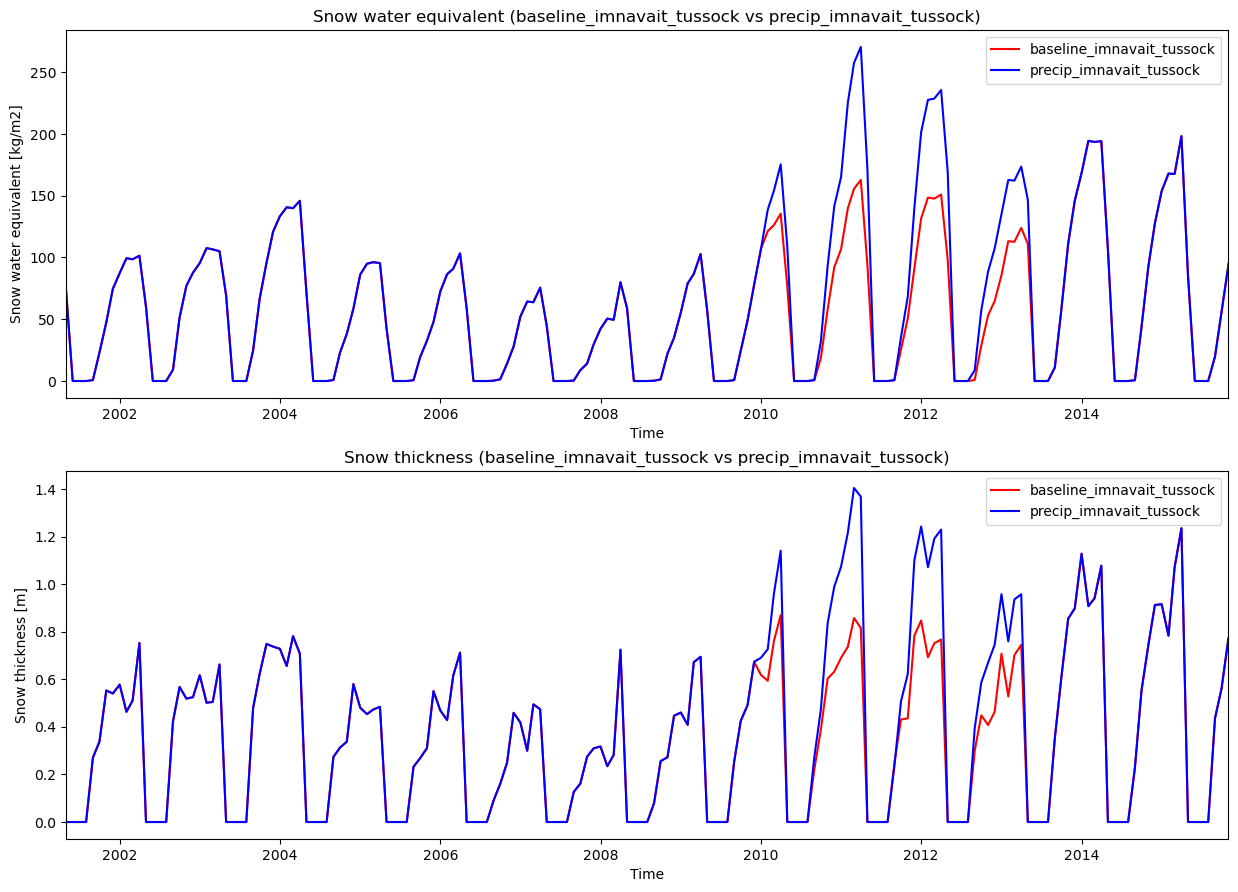

In [5]:
############################################################################
#select x axis limits
xaxis_limis = (pd.to_datetime('2001-05-01'), pd.to_datetime('2015-11-01'))
############################################################################

def yearly_data(folder, variable, PFT):
    folder= folder+'output/'+variable+'_monthly_tr.nc'
    ds = xr.open_dataset(folder) 
    data = ds.to_dataframe()
    data.reset_index(inplace=True)
    data = data[(data['x'] == 0)]
    data = data[(data['y'] == 0)]  
    data = data.drop(['x', 'y'], axis=1)
    data['time'] = data['time'].astype(pd.StringDtype()).astype('|datetime64[ns]')
    
    if 'pft' in data.columns:
        if PFT == 'PFT_on':
            print('PFT_on')
        elif PFT == 'PFT_off': 
            data = data.groupby(['time'])[variable].sum().to_frame()
            data.reset_index(inplace=True)

    return data


swe_control_model=yearly_data(model_data_control_location, 'SWE', 'PFT_off')
swe_treatment_model=yearly_data(model_data_treatment_location, 'SWE', 'PFT_off')

snowthick_control_model = yearly_data(model_data_control_location, 'SNOWTHICK', 'PFT_off')
snowthick_treatment_model = yearly_data(model_data_treatment_location, 'SNOWTHICK', 'PFT_off')


fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15, 10.5))

ax[0].plot(swe_control_model['time'], swe_control_model['SWE'],
        label='%s'% model_data_control_location.split('/')[-2], color='red')

ax[0].plot(swe_treatment_model['time'], swe_treatment_model['SWE'],
        label='%s'% model_data_treatment_location.split('/')[-2], color='blue')


ax[0].set_title('Snow water equivalent (%s vs %s)' % (model_data_control_location.split('/')[-2] , model_data_treatment_location.split('/')[-2]))
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Snow water equivalent [kg/m2]')
ax[0].legend()
ax[0].set_xlim(xaxis_limis)

ax[1].plot(snowthick_control_model['time'], snowthick_control_model['SNOWTHICK'],
        label='%s'% model_data_control_location.split('/')[-2], color='red')

ax[1].plot(snowthick_treatment_model['time'], snowthick_treatment_model['SNOWTHICK'],
        label='%s'% model_data_treatment_location.split('/')[-2], color='blue')

ax[1].set_title('Snow thickness (%s vs %s)' % (model_data_control_location.split('/')[-2] , model_data_treatment_location.split('/')[-2]))
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Snow thickness [m]')
ax[1].legend()
ax[1].set_xlim(xaxis_limis)

plt.show()

Define the soil depth and plot comparative soil temperature at given depth

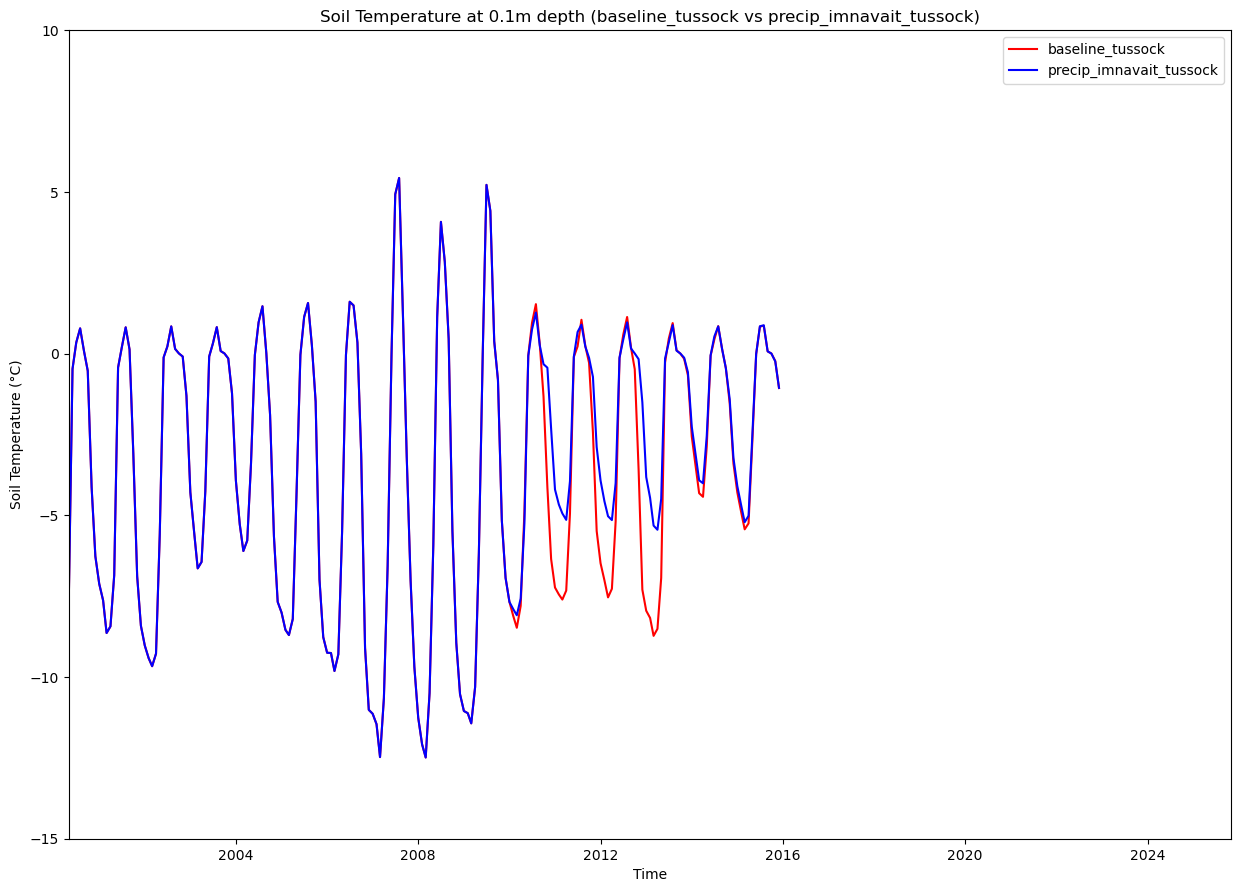

In [6]:
############################################################################
#change these parameters to relevant values
soil_depth = 0.1 #in meters
xaxis_limis = (pd.to_datetime('2000-05-01'), pd.to_datetime('2025-11-01'))
yaxis_limis = (-15, 10) #in degree C

############################################################################
def monthly_T_data(depth, model_scenario):
    folder1= model_scenario+'output/'+'TLAYER_monthly_tr.nc'
    folder2= model_scenario+'output/'+'LAYERDZ_monthly_tr.nc'

    for folder, name in [(folder1, "temp"), (folder2, "layer")]:
        ds = xr.open_dataset(folder)
        df = ds.to_dataframe()
        df.reset_index(inplace=True)
        df = df[(df['x'] == 0)]
        df = df[(df['y'] == 0)]
        df = df.drop(['x', 'y'], axis=1)
        df['time'] = df['time'].astype(pd.StringDtype()).astype('|datetime64[ns]')
        if name == "temp":
            temp = df
        else:
            layer = df
    yearly = pd.concat([temp.set_index(['time', 'layer']), layer.set_index(['time', 'layer'])], axis=1).reset_index()
    yearly['depth'] = yearly.groupby('time')['LAYERDZ'].cumsum()
    yearly_short= yearly[yearly['depth']>depth]
    yearly_lowest_layer = yearly_short.loc[yearly_short.groupby('time')['layer'].idxmin()]

    return yearly_lowest_layer


temp_control_model = monthly_T_data(soil_depth, model_data_control_location)
temp_treatment_model = monthly_T_data(soil_depth, model_data_treatment_location)

fig, ax = plt.subplots(figsize=(15, 10.5))

ax.plot(temp_control_model['time'], temp_control_model['TLAYER'],
        label='%s'% model_data_control_location.split('/')[-2], color='red')

ax.plot(temp_treatment_model['time'], temp_treatment_model['TLAYER'],
        label='%s'% model_data_treatment_location.split('/')[-2], color='blue')

# labels, legend, limits
ax.set_title('Soil Temperature at %sm depth (%s vs %s)' % (str(soil_depth), model_data_control_location.split('/')[-2] , model_data_treatment_location.split('/')[-2]))
ax.set_xlabel('Time')
ax.set_ylabel('Soil Temperature (°C)')
ax.legend()
ax.set_ylim(yaxis_limis)
ax.set_xlim(xaxis_limis)

plt.show()

Select CMT and plot GPP by PFT

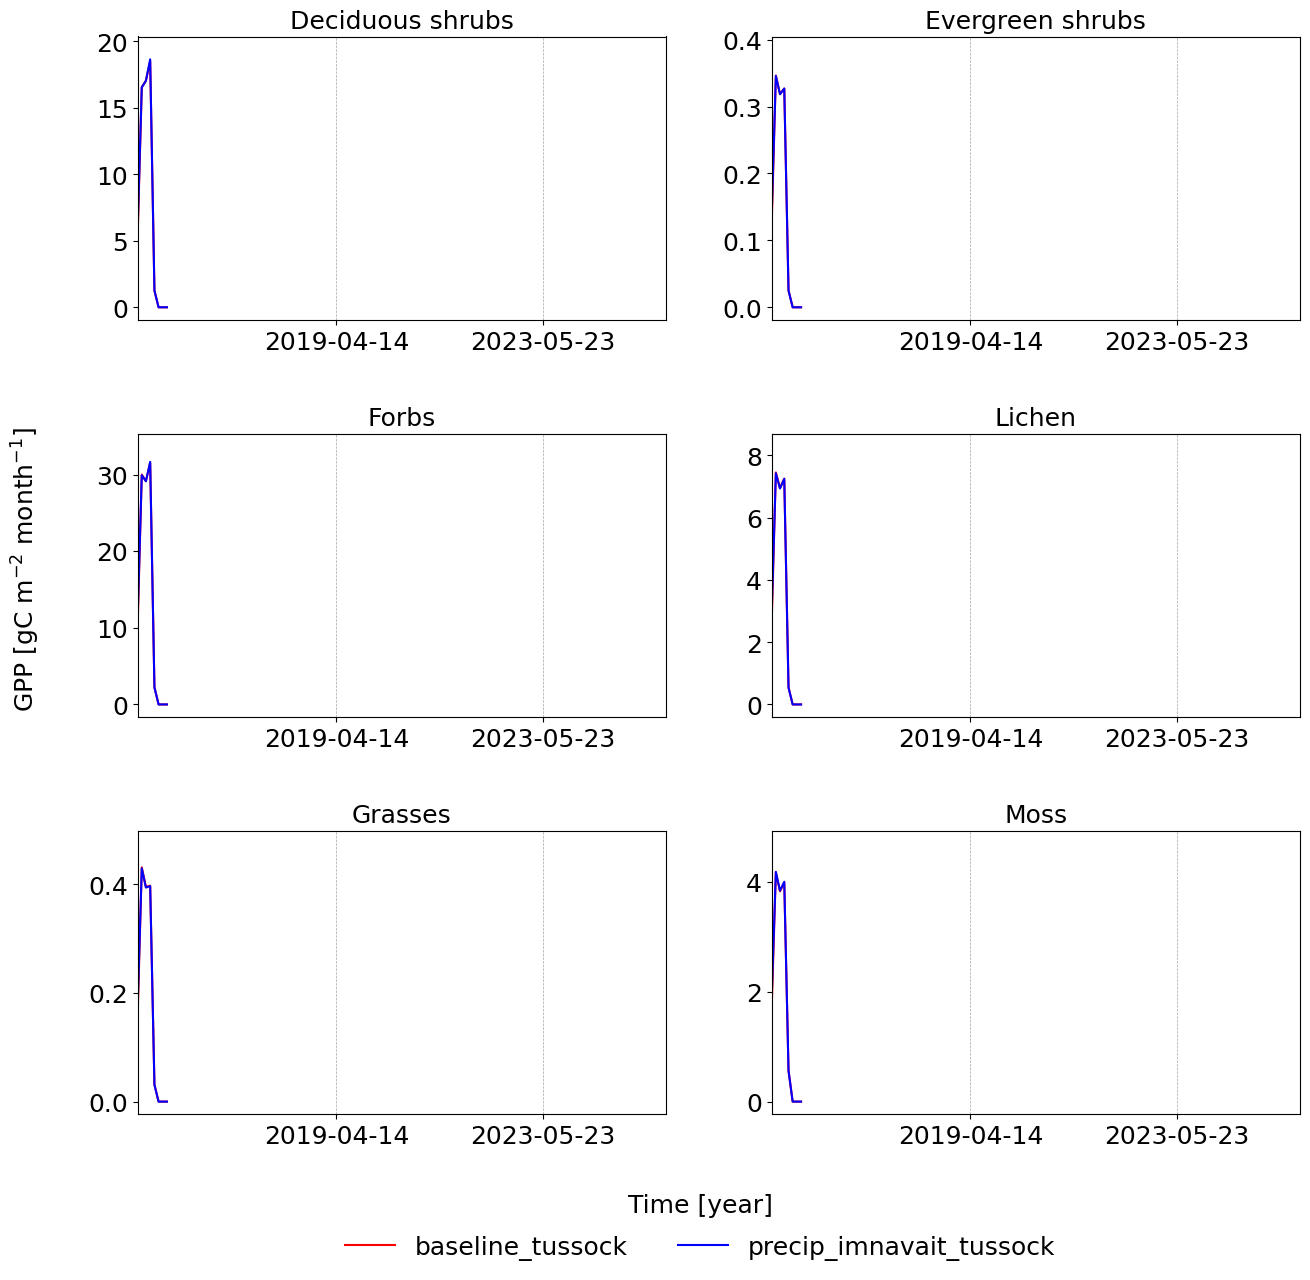

In [7]:
############################################################################
#select the appropriate community type
community_type = 'heath' #options are 'tussock', 'wet_sedge', 'heath'
#select x axis limits
xaxis_limis = (pd.to_datetime('2015-05-01'), pd.to_datetime('2025-11-01'))
############################################################################
def monthly_data(folder, variable, PFT, pftnumber):
    folder= folder+'output/'+variable+'_monthly_tr.nc'
    ds = xr.open_dataset(folder)
    data = ds.to_dataframe()
    data.reset_index(inplace=True)
    data = data[(data['x'] == 0)]
    data = data[(data['y'] == 0)]  
    data = data.drop(['x', 'y'], axis=1)
    data['time'] = data['time'].astype(pd.StringDtype()).astype('|datetime64[ns]')
    
    if 'pft' in data.columns:
        if PFT == 'PFT_on':
            data= data[data['pft'] == pftnumber]
        elif PFT == 'PFT_off':
            data = data.groupby(['time'])[variable].sum().to_frame()
            data.reset_index(inplace=True)   
    return data


pft_numbers_tussock = {
    'Betula shrubs': 0,
    'Decidious shrubs': 1,
    'Evergreen shrubs': 2,
    'Sedges': 3,
    'Forbs': 4,
    'Lichen': 5,
    'Feathermoss': 6,
    'Sphagnum': 8
}
pft_numbers_wet_sedge = {
    'Deciduous shrubs': 0,
    'Sedges': 1,
    'Grasses': 2,
    'Forbs': 3,
    'Lichen': 4,
    'Feathermoss': 5,
    'Sphagnum': 6
}
pft_numbers_heath = {
    'Deciduous shrubs': 0,
    'Evergreen shrubs': 1,
    'Forbs': 2,
    'Lichen': 3,
    'Grasses': 4,
    'Moss': 5
}  

cmt=f"pft_numbers_{community_type}"
cmt = globals()[cmt]


fig, ax = plt.subplots((len(cmt)+1)//2, 2, figsize=(15, 14))


for i in range(len(cmt)):
    ax1 = ax[i//2, i%2]
    gpp= monthly_data(model_data_control_location,'GPP', 'PFT_on',i)
    ax1.plot(gpp['time'], gpp['GPP'], label='%s control'% model_data_control_location.split('/')[-2], color='red')

    gpp= monthly_data(model_data_treatment_location,'GPP', 'PFT_on',i)
    ax1.plot(gpp['time'], gpp['GPP'], label='%s treatment'% model_data_treatment_location.split('/')[-2], color='blue')

    ax1.set_xlim(xaxis_limis)
    ax1.set_title(list(cmt.keys())[i], fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=18)#, width=1.5, length=6)
    ax1.grid(axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    #limt number of xaxis ticks to 6
    ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
plt.subplots_adjust(hspace=0.4)
fig.text(0.04, 0.5, 'GPP [gC m$^{-2}$ month$^{-1}$]', va='center', rotation='vertical', fontsize=18)
fig.text(0.5, 0.04, 'Time [year]', ha='center', fontsize=18)
leg = fig.legend(['%s' % model_data_control_location.split('/')[-2], '%s' % model_data_treatment_location.split('/')[-2]], fontsize=18, loc='lower center', frameon=False, bbox_to_anchor=(0.5, -0.01), ncol=3)


Plot the active layer depth

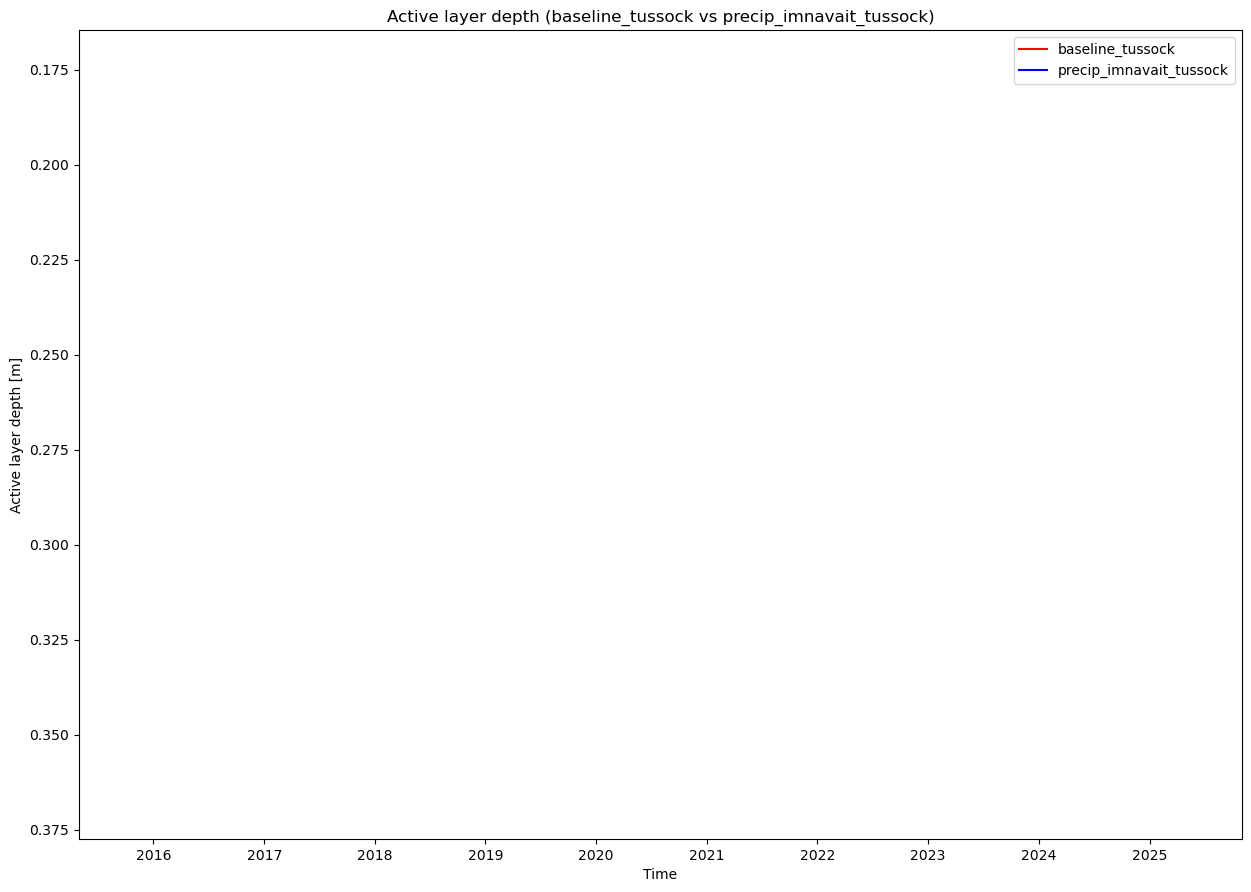

In [8]:
############################################################################
#re-select x axis limits
xaxis_limis = (pd.to_datetime('2015-05-01'), pd.to_datetime('2025-11-01'))
############################################################################

def yearly_data(folder, variable, PFT):
    folder= folder+'output/'+variable+'_yearly_tr.nc'
    ds = xr.open_dataset(folder) 
    data = ds.to_dataframe()
    data.reset_index(inplace=True)
    data = data[(data['x'] == 0)]
    data = data[(data['y'] == 0)]  
    data = data.drop(['x', 'y'], axis=1)
    data['time'] = data['time'].astype(pd.StringDtype()).astype('|datetime64[ns]')
    
    if 'pft' in data.columns:
        if PFT == 'PFT_on':
            print('PFT_on')
        elif PFT == 'PFT_off': 
            data = data.groupby(['time'])[variable].sum().to_frame()
            data.reset_index(inplace=True)

    return data


ald_control_model=yearly_data(model_data_control_location, 'ALD', 'PFT_off')
ald_treatment_model=yearly_data(model_data_treatment_location, 'ALD', 'PFT_off')

fig, ax = plt.subplots(figsize=(15, 10.5))

ax.plot(ald_control_model['time'], ald_control_model['ALD'],
        label='%s'% model_data_control_location.split('/')[-2], color='red')

ax.plot(ald_treatment_model['time'], ald_treatment_model['ALD'],
        label='%s'% model_data_treatment_location.split('/')[-2], color='blue')


ax.set_title('Active layer depth (%s vs %s)' % (model_data_control_location.split('/')[-2] , model_data_treatment_location.split('/')[-2]))
ax.set_xlabel('Time')
ax.set_ylabel('Active layer depth [m]')
ax.legend()
ax.set_xlim(xaxis_limis)
ax.invert_yaxis()

plt.show()
